In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


In [0]:
import nltk
from nltk.corpus import stopwords
import string as s
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [0]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [0]:
train.shape

(7613, 5)

In [0]:
test.shape

(3263, 4)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

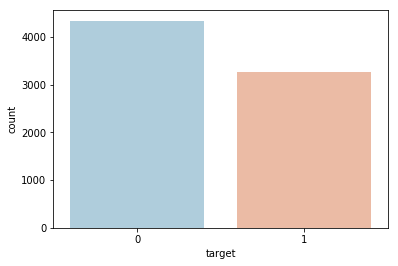

In [0]:
sns.countplot(x='target',data=train,palette='RdBu_r')

# Data Preprocessing

In [0]:
def tokenization(text):
    word = text.split()
    return word
train['text'] = train['text'].apply(tokenization)
test['text'] = test['text'].apply(tokenization)

In [0]:
def lowercase(word):
    new_word=[]
    for i in word:
        i=i.lower()
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(lowercase)
test['text'] = test['text'].apply(lowercase)    

In [0]:
def remove_punctuations(word):
    new_word=[]
    for i in word:
        for j in s.punctuation:
            i = i.replace(j,'')
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_punctuations)
test['text'] = test['text'].apply(remove_punctuations)            

In [0]:
def remove_numbers(word):
    no_num_word=[]
    new_word=[]
    for i in word:
        for j in s.digits:    
            i=i.replace(j,'')
        no_num_word.append(i)
    for i in no_num_word:
        if i!='':
            new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_numbers)
test['text'] = test['text'].apply(remove_numbers)    

In [0]:
def remove_stopwords(word):
    stop = stopwords.words('english')
    new_word=[]
    for i in word:
        if i not in stop:
            new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)  

In [0]:
def remove_spaces(word):
    new_word=[]
    for i in word:
        i=i.strip()
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(remove_spaces)
test['text'] = test['text'].apply(remove_spaces)  

In [0]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatzation(word):
    new_word=[]
    for i in word:
        i=lemmatizer.lemmatize(i)
        new_word.append(i)
    return new_word
train['text'] = train['text'].apply(lemmatzation)
test['text'] = test['text'].apply(lemmatzation)  

In [0]:
train['text'] = train['text'].apply(lambda x: ''.join(i+' ' for i in x))
test['text'] = test['text'].apply(lambda x: ''.join(i+' ' for i in x))

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
train1 = vec.fit_transform(train['text'])
test1 = vec.transform(test['text'])

In [0]:
gnb=GaussianNB()
def select_model(x,y,model):
    scores=cross_val_score(model,x,y,cv=5,scoring='f1')
    acc=np.mean(scores)
    return acc
select_model(train1.toarray(),train['target'],gnb)

0.6036576144745978

In [0]:
lr = LogisticRegression()
select_model(train1.toarray(),train['target'],lr)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.5946918923511904

In [0]:
clf_NB = MultinomialNB()
select_model(train1.toarray(),train['target'],clf_NB)

0.6603502500704101

# TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
train2 = tfidf.fit_transform(train['text'])
test2 = tfidf.transform(test['text'])

In [0]:
select_model(train2.toarray(),train['target'],gnb)

0.5914058411211223

In [0]:
select_model(train2.toarray(),train['target'],lr)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.5711131611492783

In [0]:
clf_NB = MultinomialNB()
select_model(train1.toarray(),train['target'],clf_NB)

0.6603502500704101

In [0]:
rf = RandomForestClassifier(n_estimators=10)
select_model(train2.toarray(),train['target'],rf)

In [0]:
clf_NB.fit(train2.toarray(),train['target'])
pred = clf_NB.predict(test2.toarray())
pred[:15]

In [0]:
# submission_df = {"id":test['id'],
#                  "target":pred}
# submission = pd.DataFrame(submission_df)
# submission.to_csv('submission_df.csv',index=False)